# Chapter 2.2: GAN

Let's start with the usual boilerplate from page xxiv:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # The Answer to Life, the Universe, and Everything

I've found the code for ResNetGenerator and ResNetBlock [here](https://freecontent.manning.com/pytorch-crash-course-part-3/), though I should probably just look up the original notebook.

In [2]:
class ResNetBlock(nn.Module):
    
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)
        
    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                      nn.InstanceNorm2d(dim),
                      nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                      nn.InstanceNorm2d(dim)]
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [3]:
class ResNetGenerator(nn.Module):
    
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()
        
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        
        model = [nn.ReflectionPad2d(3),
                nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                nn.InstanceNorm2d(ngf),
                nn.ReLU(True)]
        
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                               stride=2, padding=1, bias=True),
                     nn.InstanceNorm2d(ngf * mult * 2),
                     nn.ReLU(True)]
            
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]
                
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                            kernel_size=3, stride=2,
                                            padding=1, output_padding=1, bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
                
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, input):
        return self.model(input)

Now, we can try setting up an instance of ResNetGenerator.

In [4]:
netG = ResNetGenerator()

(Turn this into a code block if you need to download this again.  Note:  I had to download the file and upload it -- for some reason, using wget appeared to only get ~ 4MB, instead of the full 41MB.)

!wget https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse2zebra_0.4.0.pth

In [5]:
!wget https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse2zebra_0.4.0.pth

--2020-10-18 13:32:05--  https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch2/horse2zebra_0.4.0.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘horse2zebra_0.4.0.pth’

horse2zebra_0.4.0.p     [ <=>                ]  80.60K   494KB/s    in 0.2s    

2020-10-18 13:32:06 (494 KB/s) - ‘horse2zebra_0.4.0.pth’ saved [82533]



Now that we've got the weights, let's load them:

In [8]:
model_path = './horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [9]:
# Now we put the model in eval mode...
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [10]:
from PIL import Image
from torchvision import transforms

In [11]:
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor()])

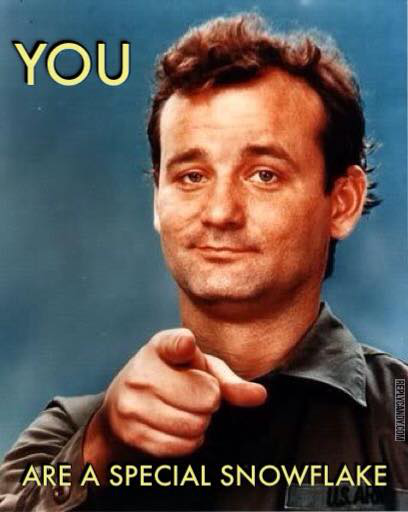

In [21]:
img = Image.open('/home/aardvark/Pictures/Billy-Murray-You-Are-a-Special-Snowflake-Meme.jpg')
img

In [22]:
# Transform...
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

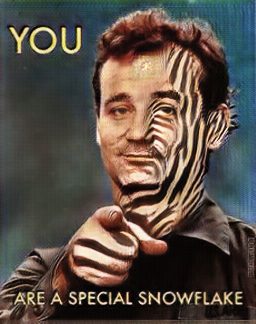

In [23]:
batch_out = netG(batch_t)
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img